In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import glob
import os
from scipy.io import loadmat
from filterpy.kalman import KalmanFilter
import math
import cv2
import seaborn as sns

In [4]:
# Insert paths for parquets and matlab files

parquet_path = r'C:\Users\OfekSapir\Desktop\reptile_lab\retpile_lab\predictions'
mat_path = r'C:\Users\OfekSapir\Desktop\reptile_lab\retpile_lab\mat_data'

Functions

In [36]:
# Data preparation
def data_prep(parquet, mat):
    # Extract relevant data from the DLC model predictions (parquet) and from the arena data (mat file)
    # Input parquet file with the DLC model predicted coordinates of the body parts, matlab file with data from the arena
    # Output data frame to use for all the other functions
    
    # DLC probabilities
    model_nose_prob = parquet[('nose', 'prob')]
    
    # Get relevant columns
    raw = parquet[[('nose', 'x'), ('nose', 'y'), ('time', ''), ('angle', ''), ('nose', 'cam_x'), ('nose', 'cam_y'), ('left_ear', 'cam_x'), ('left_ear', 'cam_y'), ('right_ear', 'cam_x'), ('right_ear', 'cam_y')]].copy()
    raw.columns = raw.columns.map('_'.join)
    raw['diff_x'] = raw['nose_x'].diff().abs()
    raw['diff_y'] = raw['nose_y'].diff().abs()
    
    # Prepare nose data with differential
    nose_x = raw['nose_x'].tolist()
    nose_y = raw['nose_y'].tolist()
    nose_x_diff = raw['diff_x']
    nose_y_diff = raw['diff_y']
    
    # Pixels coordinates data
    nose_cam_x = raw['nose_cam_x'].tolist()
    nose_cam_y = raw['nose_cam_y'].tolist()
    left_ear_cam_x = raw['left_ear_cam_x'].tolist()
    left_ear_cam_y = raw['left_ear_cam_y'].tolist()
    right_ear_cam_x = raw['right_ear_cam_x'].tolist()
    right_ear_cam_y = raw['right_ear_cam_y'].tolist()
    
    # Prepare time delta
    time_unix = pd.to_datetime(raw['time_'], unit='s') # Creating Unix time
    time_delta = (time_unix - time_unix.min()).dt.total_seconds() # Creating time from zero for plot
    
    # Determine trial frames from mat
    start_frames = list(mat['arenaCSVs']['startFrameSh'])[0][0]
    end_frames = list(mat['arenaCSVs']['endFramSh'])[0][0]
    
    try:
        assert len(start_frames) == len(end_frames), "Mismatch in start and end frame lengths"
    except AssertionError as e:
        print(f"Warning: {e}. Proceeding, but results may be incorrect.")
    
    frame_range_lst = []
    for i in range(len(start_frames)):
        start_value = int(start_frames[i].item()) if isinstance(start_frames[i], (np.ndarray, np.generic)) else int(start_frames[i])
        end_value = int(end_frames[i].item()) if isinstance(end_frames[i], (np.ndarray, np.generic)) else int(end_frames[i])
        frame_range_lst.append(range(start_value, end_value))
    
    # Set angle
    angle = raw['angle_']
    
    # Set index
    index = list(range(len(raw)))
    
    # Determine which frames are in the trial 
    index_max = max(r.stop for r in frame_range_lst)
    in_trial = [any(i in r for r in frame_range_lst) for i in range(index_max)]
    in_trial.extend([False] * (len(index) - len(in_trial)))
    
    data = pd.DataFrame({
        'frame_num': index, 
        'time_from_zero': time_delta, 
        'nose_x': nose_x, 
        'nose_y': nose_y, 
        'nose_diff_x': nose_x_diff,
        'nose_diff_y': nose_y_diff,
        'angle': angle, 
        'nose_prediction_probability': model_nose_prob,
        'nose_cam_x': nose_cam_x,
        'nose_cam_y': nose_cam_y,
        'left_ear_cam_x': left_ear_cam_x,
        'left_ear_cam_y': left_ear_cam_y,
        'right_ear_cam_x': right_ear_cam_x,
        'right_ear_cam_y': right_ear_cam_y,
        'in_trial': in_trial[:len(index)]
          })
    
    return data

In [37]:
# Screen view probability calculation
def screen_view_probability_cal(data):
    # Calculates the probability of an animal of viewing the screen
    # Input the data frame extracted by the function data_prep
    # Output the data frame with a column of probability for the animal to see the screen at each frame
    
    # Define the target angle (pi/2 radians)
    reference_angle_1 = 0
    reference_angle_2 = np.pi
    
    # Calculate the deviation from the target angles
    data['angle_deviation'] = np.where(
        (reference_angle_1 < data['angle']) & (data['angle'] < reference_angle_2),
        0,
        np.where(
            (3 * np.pi / 2 < data['angle']) & (data['angle'] < 2 * np.pi),
            np.abs(2 * np.pi - (data['angle'] - reference_angle_1)),
        np.where(
            (np.pi < data['angle']) & (data['angle'] < 3 * np.pi / 2),
            np.abs(data['angle'] - reference_angle_2),
            np.nan  # If the angle does not fall within these ranges
        )))
    
    # Normalize the deviation to create a probability score
    threshold = np.pi / 2
    data['probability'] = np.clip(1 - (data['angle_deviation'] / threshold), 0, 1)
    
    return data

In [38]:
# Filtering by probability and positions based on given parameters
def prob_and_pos_filters(data, prob_threshold=None, pos_std_factor=None):
    # Filter out frames with abnormal prediction probability values or differential values between frames
    # Input the data frame extracted by the function data_prep, the probability threshold wanted which underneath it the frames will be filtered out, the positional std factor which sets the distance from the average to filter out from 
    # Output the data frame contains only the frames that matches the parameters of the function with 
    
    # Filter rows with low probability
    if prob_threshold is not None:
        filtered_data = data[data['nose_prediction_probability'] >= prob_threshold].copy()
    else:
        filtered_data = data.copy()
    
    
    # Calculate mean and std for positional differences
    mean_diff_x = np.mean(data['nose_diff_x'].fillna(0))
    std_diff_x = np.std(data['nose_diff_x'].fillna(0))
    
    mean_diff_y = np.mean(data['nose_diff_y'].fillna(0))
    std_diff_y = np.std(data['nose_diff_y'].fillna(0))
    
    # Calculate positional threshold
    if pos_std_factor is not None:
        x_threshold = mean_diff_x + pos_std_factor * std_diff_x
        y_threshold = mean_diff_y + pos_std_factor * std_diff_y
        # Filter rows with high location differences
        filtered_data = filtered_data[
            (filtered_data['nose_diff_x'] <= x_threshold) &
            (filtered_data['nose_diff_y'] <= y_threshold)
        ]
    else:
        x_threshold = 'No X threshold was set'
        y_threshold = 'No Y threshold was set'
        filtered_data = filtered_data.copy()
    
    print(f'Nose Prediction Probability Threshold = {prob_threshold}\nPositions Difference Threshold = {x_threshold} on X axis, {y_threshold} on Y axis')
    return filtered_data

In [53]:
# Plot function nose x-y plane real world
def plot_plane(data, date, prob_threshold=0.8, path_to_save=None, save=False):
    # Extract a plot of real-world coordinates of the nose of the animal
    # Input the data frame extracted by the function data_prep, the date of the video analyzed, the screen-view probability threshold which under it the animal is defined as not viewing the screen (default threshold = 0.8), optional - whether to save the plot and a path to save it to 
    # Output a plot of the coordinates, the screen is located where the y-axis is
    
    # Assign screen sight probability for each frame
    screen_view_probability_cal(data)

    # Identify segments where probability is above 0.8
    high_prob = data['probability'] > prob_threshold

    default_color = 'black'
    highlight_color = 'red'

    plt.figure(figsize=(10, 6))
    plt.plot(data['nose_y'], data['nose_x'], color=default_color, linewidth=2)
    
    # Plot with highlighting segments based on probability
    for i in range(1, len(data)):
        color = highlight_color if high_prob.iloc[i] else default_color
        plt.plot([data['nose_y'].iloc[i-1], data['nose_y'].iloc[i]], 
                 [data['nose_x'].iloc[i-1], data['nose_x'].iloc[i]], 
                 color=color, linewidth=2)

    plt.title(f'Nose x-y Plane for {date}')
    plt.ylabel('X Coordinates (cm)')
    plt.xlabel('Y Coordinates (cm)')
    plt.grid(True)
    plt.tight_layout()

    counter = 1
    filename = os.path.join(path_to_save, f'plane_{counter}.png')
    while os.path.exists(filename):
        counter += 1
        filename = os.path.join(path_to_save, f'plane_{counter}.png')

    if save:
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        plt.savefig(filename)
    plt.show()

In [40]:
# Plot function nose x & y coordinates over time
def plot_overtime(data, date, path_to_save=None, save=False):
    # Extract a plot of the x and y coordinates of the nose over time
    # Input the data extracted by the function data_prep, the date of the video analyzed, optional - whether to save the plot and a path to save it to
    # Output a plot of the x and y coordinates of the nose separately over the time of the experiment
    
    # Assign screen sight probability for each frame
    screen_view_probability_cal(data)
     
    coordinates_col = ['nose_x', 'nose_y']
    fig, ax = plt.subplots(figsize=(15, 8))
    for col in coordinates_col:
        ax.plot(data['time_from_zero'], data[col], label=f'Coordinate of {col[-1]}')
        ax.set_title(f'Location of Pogona Over Time for {date}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Coordinates (cm)')
        ax.grid(True)
        ax.legend()
    plt.tight_layout()

    counter = 1
    filename = os.path.join(path_to_save, f'overtime_plane_{counter}.png')
    while os.path.exists(filename):
        counter += 1
        filename = os.path.join(path_to_save, f'overtime_plane_{counter}.png')
        
    if save:
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        plt.savefig(filename)
    plt.show()

In [52]:
# First Kalman filter (self written)
def kalman_filter_1(coordinates_data, initial_value, process_variance=1e-2, measurement_variance=0.5, estimated_error=0.1):
    # Filter the coordinates of a body part by the kalman filter method
    # Input an array of coordinates of one axis of a certain body part (e.g., x-axis column of the nose), the kalman filter parameters described below  
    # Output the same array after employing the filter
    # Kalman filter parameters explanation - 
    # Initial value - The first value of the data
    # Process variance - Smaller value for smooth data
    # Measurement variance - Measurement noise, higher value for noisy data 
    # Estimated error - Small values for trustworthy starting point
    
    n = len(coordinates_data)
    kalman_estimates = np.zeros(n)
    kalman_gain = 0

    # Initial guesses
    current_estimate = initial_value
    current_error = estimated_error

    for i in range(n):
        # Kalman Gain
        kalman_gain = current_error / (current_error + measurement_variance)
        
        # Update estimate with measurement
        current_estimate = current_estimate + kalman_gain * (coordinates_data[i] - current_estimate)
        kalman_estimates[i] = current_estimate
        
        # Update the error covariance
        current_error = (1 - kalman_gain) * current_error + process_variance
    
    return kalman_estimates

In [42]:
# Second Kalman filter (by KalmanFilter package)
def kalman_filter_2(coordinates_data):
    # Filter the coordinates of a body part by the kalman filter method
    # Input an array of coordinates of one axis of a certain body part (e.g., x-axis of the nose)
    # Output the same array after employing the filter
    
    kf = KalmanFilter(dim_x=2, dim_z=1)  # 2 states (position, velocity), 1 measurement
    
    # Initial state: assume starting at first coordinate with zero initial velocity
    kf.x = np.array([[coordinates_data[0]], [0]])  
    
    # State transition matrix (F)
    dt = 1  # Assuming 1 frame step; adjust if time interval is different
    kf.F = np.array([[1, dt], [0, 1]])
    
    # Measurement function (H): we only measure position
    kf.H = np.array([[1, 0]])
    
    # Measurement noise covariance (R): based on data variance
    kf.R = np.array([[np.var(coordinates_data) * 0.01]])  # Scaled down to smooth more aggressively
    
    # Process noise covariance (Q)
    kf.Q = np.array([[1e-4, 0], [0, 1e-4]])  # Small values to maintain smoothness
    
    # Initial state covariance (P)
    kf.P = np.eye(2) * 500
    
    # Apply the filter
    smoothed_coords = []
    for z in coordinates_data:
        kf.predict()
        kf.update([[z]])
        smoothed_coords.append(kf.x[0, 0])  # Extract filtered position
    
    return np.array(smoothed_coords)

In [43]:
def create_labeled_video(data, input_video_path, output_video_path):
    # Create labeled video based on the data extracted from data_prep function, can be filtered or raw
    # Input the data frame extracted by the function data_prep, the original video path, the path to save the new video
    # Output a labeled video saved to the path mentioned
    
    frame_num = [i for i in range(len(data))]
    frame_annotations = {}
    for frame in frame_num:
        frame_annotations[frame] = [(data['nose_cam_x'].iloc[frame], data['nose_cam_y'].iloc[frame], 'nose'), (data['left_ear_cam_x'].iloc[frame], data['left_ear_cam_y'].iloc[frame], 'left_ear'), (data['right_ear_cam_x'].iloc[frame], data['right_ear_cam_y'].iloc[frame], 'right_ear')]
    
    # Load the video
    cap = cv2.VideoCapture(input_video_path)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()  # Read a frame
        if not ret:
            break  
    
        # Add annotations to the frame if they exist for the current frame index
        if frame_idx in frame_annotations:
            for (x, y, label) in frame_annotations[frame_idx]:
                x, y = int(x), int(y)
                cv2.circle(frame, (x, y), 10, (255, 0, 0), -1) 
                # Add the label near the circle
                # cv2.putText(frame, label, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                #             0.5, (0, 255, 0), 1, cv2.LINE_AA)  
    
        out.write(frame)
        frame_idx += 1
    
    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    print(f"Labeled video saved as: {output_video_path}")

Loading the data

In [44]:
# Setting up the data
parquet_files = glob.glob(os.path.join(parquet_path, '**', '*.parquet'), recursive=True)
mat_files = glob.glob(os.path.join(mat_path, '**', '*.mat'), recursive=True)

parquet_dict = {}
mat_lst = []
data_lst = []
data_lst_with_prob = []
filtered_data_lst_with_prob = []

# Load the parquets data
for i, file in enumerate(parquet_files):
    date = str(file[-17:-15] + '/' + file[-19:-17] + '/' + file[-23:-19])
    parquet_dict[date] = pd.read_parquet(file, engine='pyarrow')

# Load the matlab tables data 
for j, mat in enumerate(mat_files):
    mat_lst.append(loadmat(mat))
    
if len(parquet_dict.keys()) != len(mat_lst):
    print('Parquet files and mat files are not synced!')

In [45]:
# Preparing the data for work
for parquet_val, mat in zip(parquet_dict.values(), mat_lst):
    data_lst.append(data_prep(parquet_val, mat))

In [46]:
# Calculating screen view probabilities for the data
for data in data_lst:
    prob_data = screen_view_probability_cal(data)
    data_lst_with_prob.append(prob_data)

In [47]:
# Filtering the data based on predictions probabilities and positions difference
for data in data_lst_with_prob:
    filtered_data = prob_and_pos_filters(data)
    filtered_data_lst_with_prob.append(filtered_data)

Nose Prediction Probability Threshold = None
Positions Difference Threshold = No X threshold was set on X axis, No Y threshold was set on Y axis
Nose Prediction Probability Threshold = None
Positions Difference Threshold = No X threshold was set on X axis, No Y threshold was set on Y axis
Nose Prediction Probability Threshold = None
Positions Difference Threshold = No X threshold was set on X axis, No Y threshold was set on Y axis
Nose Prediction Probability Threshold = None
Positions Difference Threshold = No X threshold was set on X axis, No Y threshold was set on Y axis
Nose Prediction Probability Threshold = None
Positions Difference Threshold = No X threshold was set on X axis, No Y threshold was set on Y axis
Nose Prediction Probability Threshold = None
Positions Difference Threshold = No X threshold was set on X axis, No Y threshold was set on Y axis


Creating figures plots

In [48]:
labels = list(parquet_dict.keys())
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
values = [value['nose_diff_x'] for value in data_lst_with_prob]

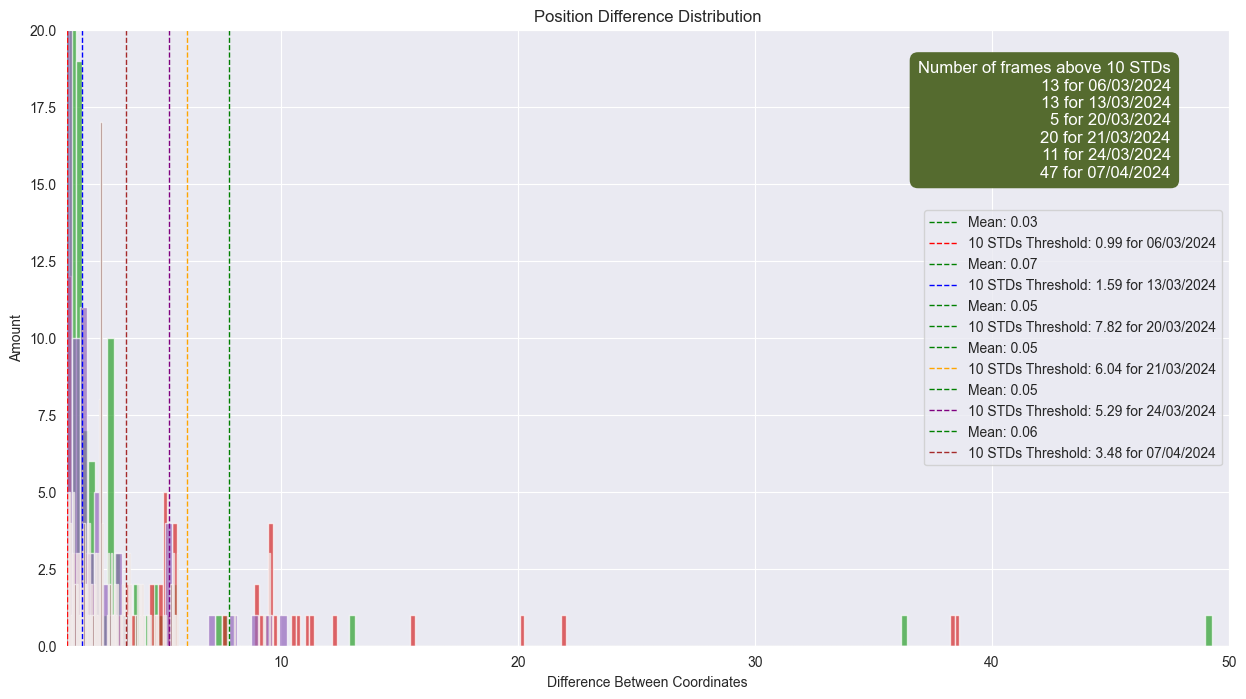

In [49]:
# Positional difference distribution histogram
fig, ax = plt.subplots(figsize=(15, 8))
above_10 = []
for label, value, color in zip(labels, parquet_dict.values(), colors):
    value['diff_x'] = value[('nose', 'x')].diff().abs()
    mean_diff_x = np.mean(value['diff_x'].dropna())
    std_diff_x = np.std(value['diff_x'].dropna())
    above_10.append((value['diff_x'] >= mean_diff_x + std_diff_x * 10).sum())
    tenth_threshold = mean_diff_x + std_diff_x * 10
    
    ax.hist(value['diff_x'], bins=200, alpha=0.7)
    plt.xlim(0.95,50)
    plt.ylim(0,20)
    ax.axvline(mean_diff_x, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean_diff_x:.2f}')
    ax.axvline(
    tenth_threshold, color=color, linestyle='dashed', linewidth=1,
    label=f'10 STDs Threshold: {tenth_threshold:.2f} for {label}'
    )

text = f"Number of frames above 10 STDs\n{above_10[0]} for {labels[0]}\n{above_10[1]} for {labels[1]}\n{above_10[2]} for {labels[2]}\n{above_10[3]} for {labels[3]}\n{above_10[4]} for {labels[4]}\n{above_10[5]} for {labels[5]}"
plt.text(
    0.95, 0.95, 
    text,
    fontsize=12,
    color="white",
    ha="right",  
    va="top",     
    transform=ax.transAxes,  
    bbox=dict(facecolor="darkolivegreen", edgecolor="none", boxstyle="round,pad=0.5")
)
plt.xlabel('Difference Between Coordinates')
plt.ylabel('Amount')
plt.legend()
plt.title('Position Difference Distribution')
plt.show()

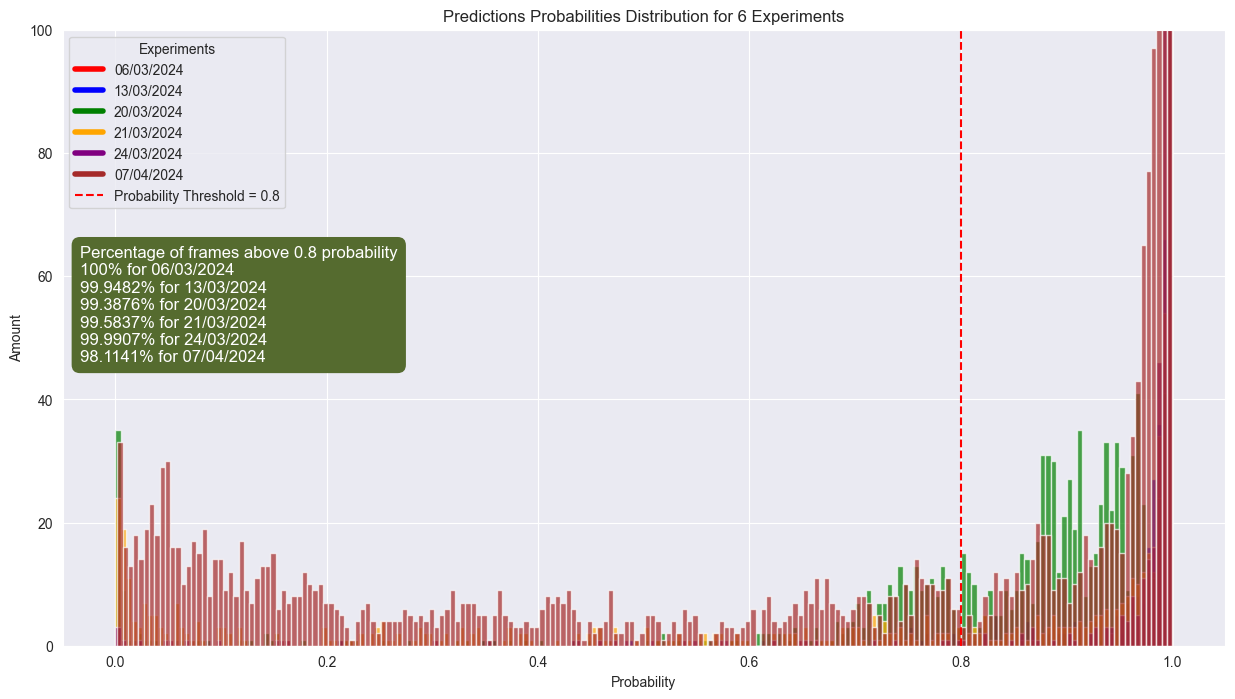

In [50]:
# Probabilities distribution histogram
fig, ax = plt.subplots(figsize=(15, 8))
data = [v[('nose', 'prob')] for v in parquet_dict.values()]
labels = list(parquet_dict.keys())
patches = []
above_80_per = []

for label, value, color in zip(labels, data, colors):
    n, bins, patches_hist = ax.hist(value, bins=200, alpha=0.7, color=color, label=label)
    patches.append(plt.Line2D([0], [0], color=color, lw=4, label=label))
    above_80_per.append(((value >= 0.8).sum() / value.sum()) * 100)

text = f"Percentage of frames above 0.8 probability\n{int(above_80_per[0])}% for {labels[0]}\n{round(above_80_per[1],4)}% for {labels[1]}\n{round(above_80_per[2],4)}% for {labels[2]}\n{round(above_80_per[3],4)}% for {labels[3]}\n{round(above_80_per[4],4)}% for {labels[4]}\n{round(above_80_per[5],4)}% for {labels[5]}"
plt.text(
    0.015, 0.65, 
    text,
    fontsize=12,
    color="white",
    ha="left",  
    va="top",     
    transform=ax.transAxes,  
    bbox=dict(facecolor="darkolivegreen", edgecolor="none", boxstyle="round,pad=0.5")
)

plt.ylim(0,100)
plt.axvline(x=0.8, color='red', linestyle='--', linewidth=1.5, label="Probability Threshold = 0.8")
plt.legend(handles=patches + [plt.Line2D([0], [0], color='red', linestyle='--', lw=1.5, label="Probability Threshold = 0.8")],
           loc='upper left', title="Experiments")
plt.xlabel('Probability')
plt.ylabel('Amount')
plt.title('Predictions Probabilities Distribution for 6 Experiments')
plt.show()

Nose Prediction Probability Threshold = None
Positions Difference Threshold = 0.9875471490436526 on X axis, 1.654548654386517 on Y axis


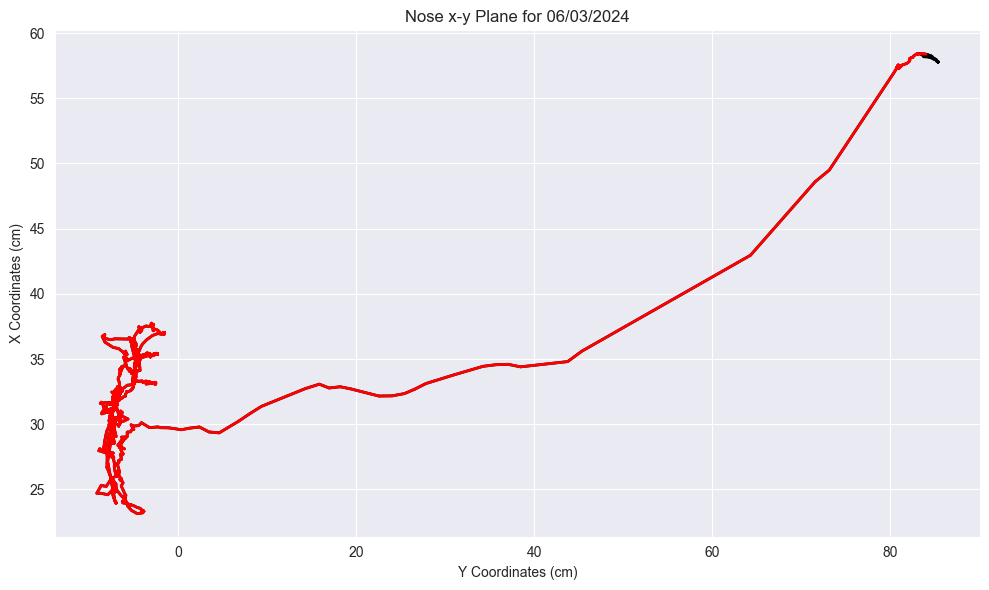

Nose Prediction Probability Threshold = None
Positions Difference Threshold = 1.589404965834939 on X axis, 3.678857725541036 on Y axis


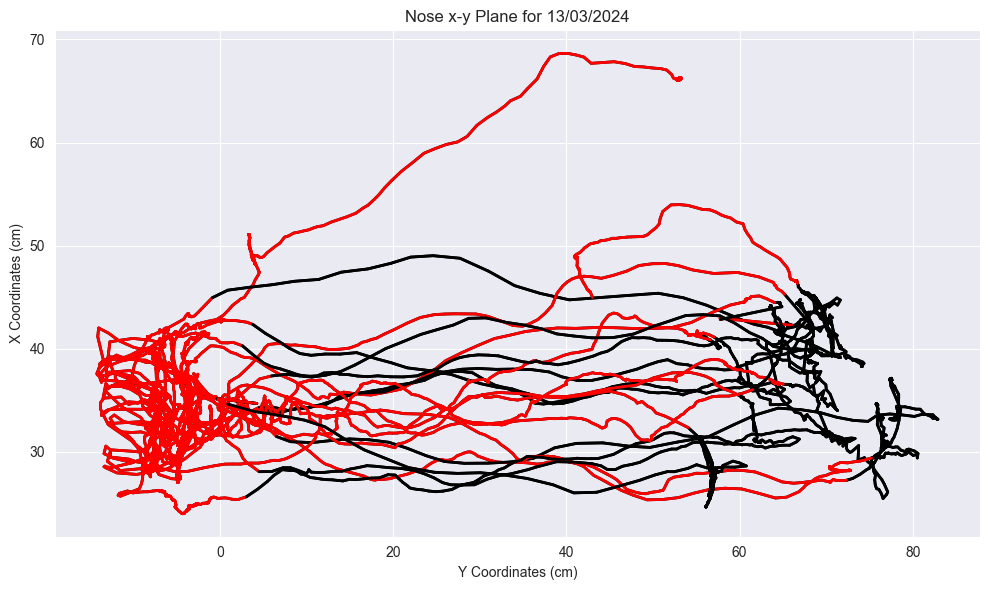

Nose Prediction Probability Threshold = None
Positions Difference Threshold = 7.823430299926522 on X axis, 16.1818435520777 on Y axis


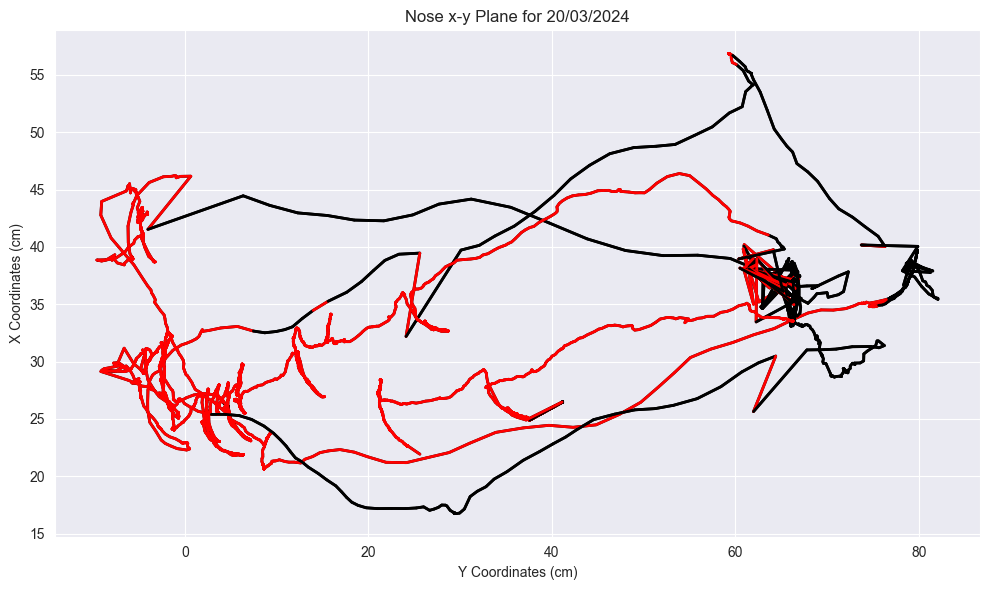

Nose Prediction Probability Threshold = None
Positions Difference Threshold = 6.041266608725889 on X axis, 4.828737096401915 on Y axis


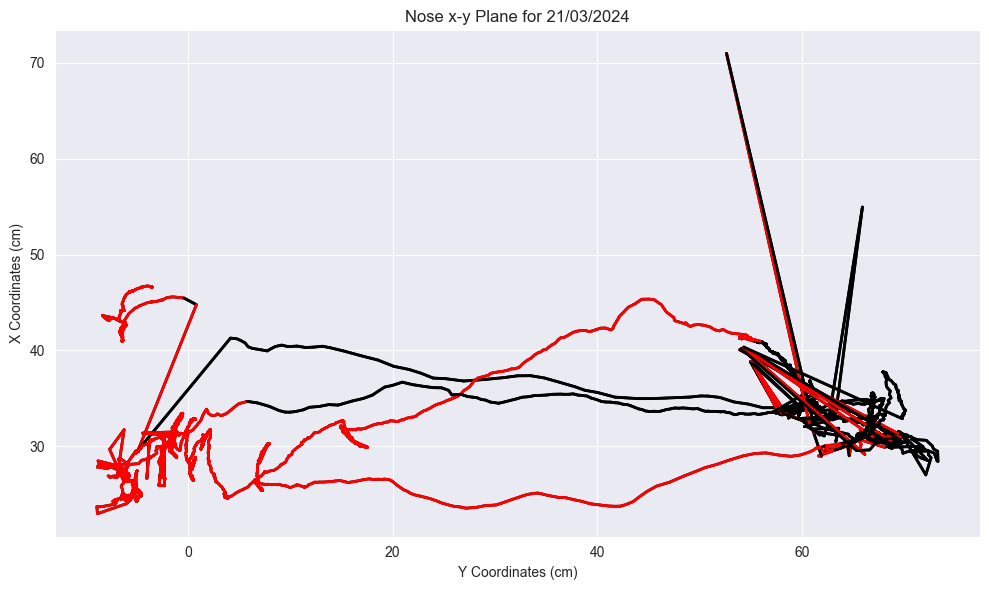

Nose Prediction Probability Threshold = None
Positions Difference Threshold = 5.292796596613727 on X axis, 5.059021070738704 on Y axis


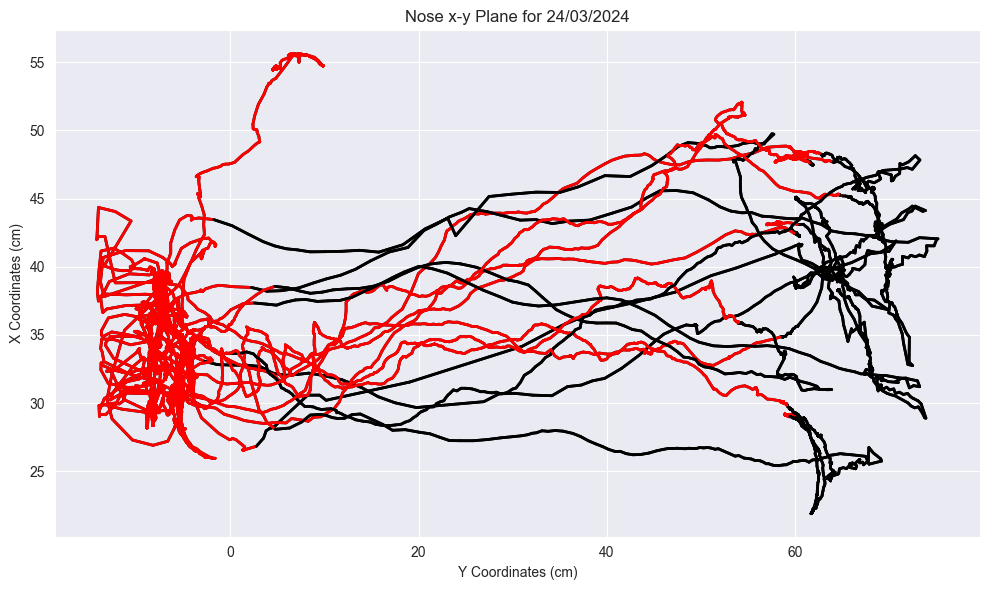

Nose Prediction Probability Threshold = None
Positions Difference Threshold = 3.476355630038121 on X axis, 7.819573853847456 on Y axis


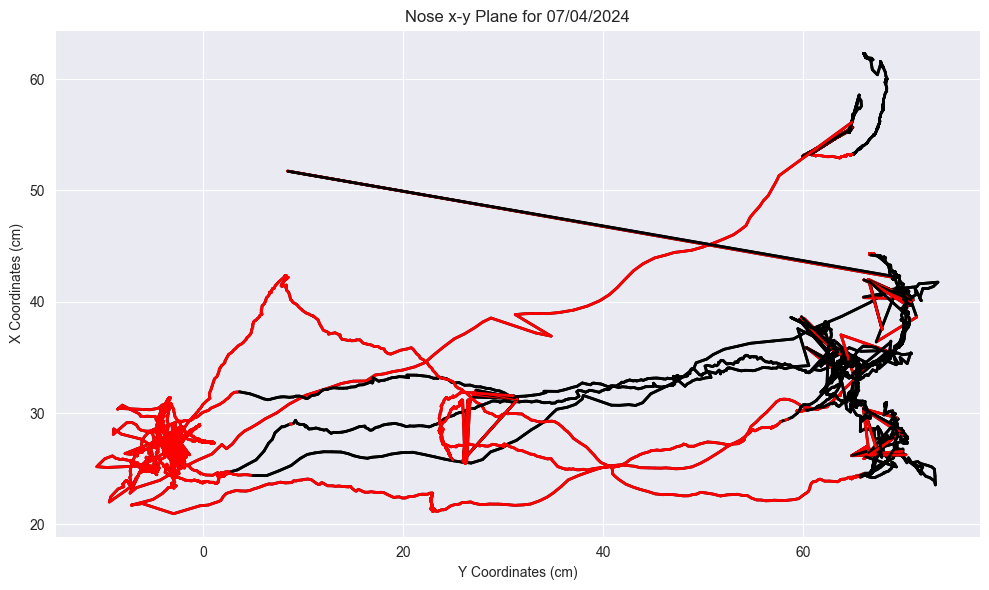

In [51]:
# Nose x-y plane real world plot
for i, data in enumerate(data_lst_with_prob):
    new_data = prob_and_pos_filters(data, pos_std_factor=10)
    # kf1_data = data.copy()
    # nose_x_kf1 = np.array(kf1_data['nose_x'])
    # nose_y_kf1 = np.array(kf1_data['nose_y'])
    # # kalman_filter_1 parameters
    # process_variance = 1e-4  
    # measurement_variance = 0.001 
    # estimated_error = 0.1  
    # initial_value_x = nose_x_kf1[0]
    # initial_value_y = nose_y_kf1[0]
    # kf1_data['nose_x'] = kalman_filter_1(nose_x_kf1, process_variance, measurement_variance, estimated_error, initial_value_x)
    # kf1_data['nose_y'] = kalman_filter_1(nose_y_kf1, process_variance, measurement_variance, estimated_error, initial_value_y)
    # 
    # kf2_data = data.copy()
    # kf2_data['nose_x'] = kalman_filter_2(kf2_data['nose_x'].values)
    # kf2_data['nose_y'] = kalman_filter_2(kf2_data['nose_y'].values)
    
    plot_plane(new_data, f'{list(parquet_dict.keys())[i]}', path_to_save=r'C:\Users\OfekSapir\Desktop\reptile_lab\retpile_lab\Assignment Pics\all experiments simple filter', save=True) # No filter plot
    # plot_plane(kf1_data, f'{list(parquet_dict.keys())[i]}, kalman filter 1', save=False) # Kalman filter 1 plot
    # plot_plane(kf2_data, f'{list(parquet_dict.keys())[i]}, kalman filter 2', save=False) # Kalman filter 2 plot

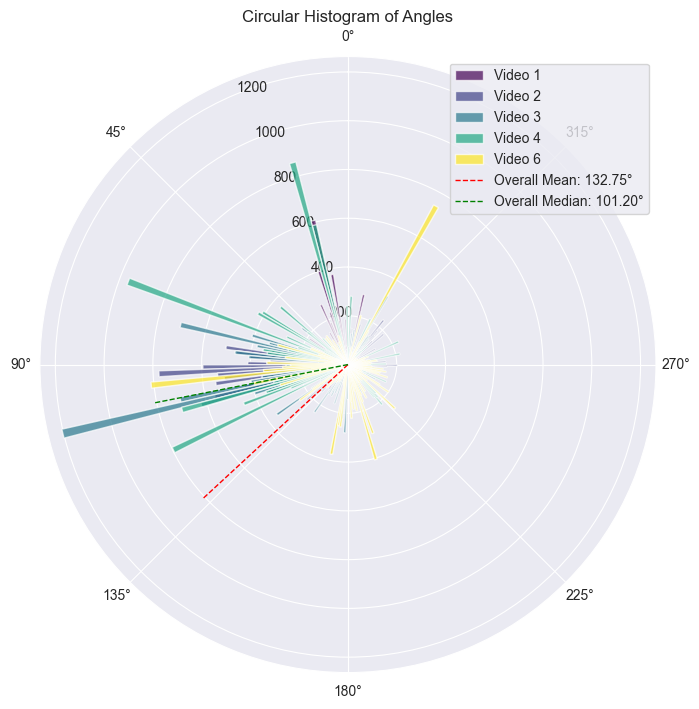

In [22]:
# Angle distribution circular plot
plt.figure(figsize=(8, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(mat_lst)))

mean_lst = []
median_lst = []

ax = plt.subplot(111, polar=True)

for i, data in enumerate(data_lst_with_prob):
    if i != 4:
        angles = data['angle']
        
        median_angle = np.median(angles)
        mean_angle = np.mean(angles)
        median_lst.append(median_angle)
        mean_lst.append(mean_angle)
        
        ax.hist(angles, bins=200, color=colors[i], alpha=0.7, label=f'Video {i+1}')

overall_mean = np.mean(mean_lst)
overall_median = np.median(median_lst)

ax.plot([overall_mean, overall_mean], [0, np.max(np.histogram(angles, bins=200)[0])], 
        color='red', linestyle='dashed', linewidth=1, label=f'Overall Mean: {np.rad2deg(overall_mean):.2f}°')
ax.plot([overall_median, overall_median], [0, np.max(np.histogram(angles, bins=200)[0])], 
        color='green', linestyle='dashed', linewidth=1, label=f'Overall Median: {np.rad2deg(overall_median):.2f}°')

ax.set_theta_zero_location('N')
ax.set_theta_direction(1) 

ax.legend(loc='upper right')
ax.set_title('Circular Histogram of Angles')
plt.savefig('Circular Histogram of Angles.png')
plt.show()

In [ ]:
# Create labeled videos
input_video_path = r"C:\Users\OfekSapir\Desktop\reptile_lab\retpile_lab\Videos\top_20240407T163529.mp4"
output_video_path = r"C:\Users\OfekSapir\Desktop\reptile_lab\retpile_lab\Labeled Videos\kalman_data_labeled_video_07-10-24_take_12_pro=0.01_mea=0.001_est_err=0.001.mp4"

# Kalman filter
data_for_kalman = data_lst_with_prob[-1][['nose_cam_x', 'nose_cam_y', 'left_ear_cam_x', 'left_ear_cam_y', 'right_ear_cam_x', 'right_ear_cam_y']]
kalman_dict = {}
for col in data_for_kalman.columns:
    initial_value = np.array(data_lst_with_prob[-1][col])[0]
    kalman_dict[col] = kalman_filter_1(data_lst_with_prob[-1][col], initial_value, process_variance=1e-02, measurement_variance=0.001, estimated_error=0.001)

kalman_data = pd.DataFrame.from_dict(kalman_dict)
create_labeled_video(kalman_data, input_video_path, output_video_path)